# ML Workflow Description

### What is the goal?

Predict a used car's price from a data set.

**Steps:**
- Import data
- Explore data
- Split into test/training set
    - Stratified Sampling?
- Separate categorical/numerical features
- Create Pipeline
    - Wrangle categorical data
    - Handle missing Values
    - Scale values
    - Column transformer brings data back together
- Train models
    - Use cross-validation to select the best model
    

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_car_data(car_path, filename):
    return pd.read_csv( os.path.join(car_path,filename) )
CAR_PATH = os.path.join('./datasets','cars')
FILENAME = 'autos.csv'
cars = load_car_data(CAR_PATH, FILENAME)

In [3]:
cars.head()

,index,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,...,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,...,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,...,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,...,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,...,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,...,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
columns = cars.columns
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   index                371528 non-null  int64 
 1   dateCrawled          371528 non-null  object
 2   name                 371528 non-null  object
 3   seller               371528 non-null  object
 4   offerType            371528 non-null  object
 5   price                371528 non-null  int64 
 6   abtest               371528 non-null  object
 7   vehicleType          333659 non-null  object
 8   yearOfRegistration   371528 non-null  int64 
 9   gearbox              351319 non-null  object
 10  powerPS              371528 non-null  int64 
 11  model                351044 non-null  object
 12  kilometer            371528 non-null  int64 
 13  monthOfRegistration  371528 non-null  int64 
 14  fuelType             338142 non-null  object
 15  brand                371528 non-nu

Drop seller

In [5]:
cars['seller'].value_counts()

privat        371525
gewerblich         3
Name: seller, dtype: int64

In [6]:
cars.drop('seller',axis=1,inplace=True)

#### Replace 0 HP with NaN

In [7]:
cars['powerPS'].replace(0,np.nan,inplace=True)

#### Drop Num of Pics

In [8]:
cars.drop('nrOfPictures',axis=1,inplace=True)

#### Binary Gearbox

In [9]:
cars['gearbox'].value_counts()

manuell      274214
automatik     77105
Name: gearbox, dtype: int64

#### Binary abtest

In [10]:
cars['abtest'].value_counts()

test       192585
control    178943
Name: abtest, dtype: int64

#### Drop offerType

In [11]:
cars['offerType'].value_counts()

Angebot    371516
Gesuch         12
Name: offerType, dtype: int64

In [12]:
# Drops offerType Column
cars.drop('offerType',axis=1,inplace=True)

In [13]:
cars.drop('dateCreated',axis=1,inplace=True)

In [14]:
cars.drop('dateCrawled',axis=1,inplace=True)

In [15]:
cars.drop('lastSeen',axis=1,inplace=True)

#### Drop name axis as there are just too many names

In [16]:
cars.drop('name',axis=1,inplace=True)

#### Drop postal code just not worth it

In [17]:
cars.drop('postalCode',axis=1,inplace=True)

#### Will drop brand bc 40 categories (for now)

In [18]:
cars['brand'].value_counts().size

40

In [19]:
cars.drop('brand',axis=1,inplace=True)

#### Drop index

In [20]:
cars = cars.drop('index',axis=1)

Looking for features with lots of categories

- model has too many
- dates can be converted to numerical
- the rest are good for one-hot

In [21]:
for feature in cars.select_dtypes(int).columns:
    print(feature,cars[feature].value_counts().size)

price 5597
yearOfRegistration 155
kilometer 13
monthOfRegistration 13


In [22]:
for feature in cars.select_dtypes(object).columns:
    print(feature,cars[feature].value_counts().size)

abtest 2
vehicleType 8
gearbox 2
model 251
fuelType 7
notRepairedDamage 2


#### Remove Model

In [23]:
cars.drop('model',axis=1,inplace=True)

#### Make price in units of 1000

In [24]:
cars['price'] = cars['price']/1000

Get rid of cars less than 400 dollars and greater than 75,000

In [25]:
mask = (cars['price']> .4) & (cars['price'] < 75)
cars = cars[mask]

<br>

### Cleaner Cars dataset

In [26]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338393 entries, 0 to 371527
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   price                338393 non-null  float64
 1   abtest               338393 non-null  object 
 2   vehicleType          310238 non-null  object 
 3   yearOfRegistration   338393 non-null  int64  
 4   gearbox              324372 non-null  object 
 5   powerPS              308342 non-null  float64
 6   kilometer            338393 non-null  int64  
 7   monthOfRegistration  338393 non-null  int64  
 8   fuelType             313994 non-null  object 
 9   notRepairedDamage    281464 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 28.4+ MB


In [27]:
cars['price'].describe()

count    338393.000000
mean          6.067240
std           7.317028
min           0.408000
25%           1.500000
50%           3.455000
75%           7.850000
max          74.999000
Name: price, dtype: float64

<AxesSubplot: ylabel='Frequency'>

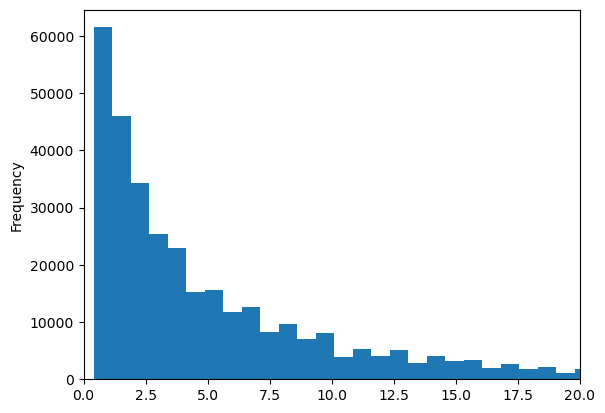

In [28]:
cars['price'].plot(kind='hist',xlim=[0,20],bins=100)

<AxesSubplot: xlabel='yearOfRegistration', ylabel='price'>

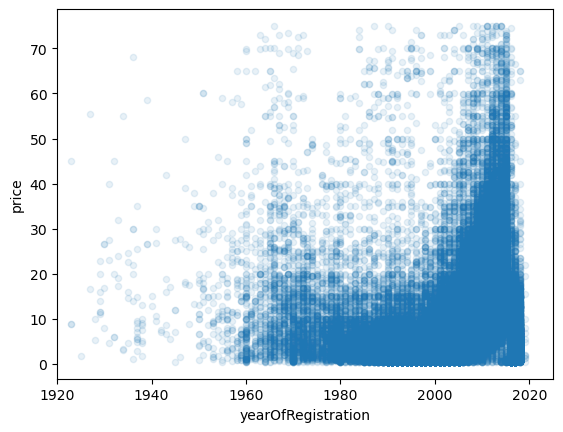

In [29]:
cars.plot(kind='scatter',y='price',x='yearOfRegistration',alpha=0.1,xlim=[1920,2025])

In [30]:
cars['yearOfRegistration'].describe()

count    338393.000000
mean       2004.446543
std          67.356229
min        1000.000000
25%        2000.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: yearOfRegistration, dtype: float64

In [31]:
cars.reset_index(drop=True,inplace=True)

## Training/Test Set

Stratified Sample of car years, 1860-2020, 7 groups of 10

In [32]:
cars['yearCat'] = pd.cut(cars['yearOfRegistration'],
                         bins = [0., 1980., 1990., 2000., 2010., np.inf],
                         labels = [1,2,3,4,5])

In [33]:
cars['yearCat'].value_counts()

4    178581
3     93240
5     55338
2      7237
1      3997
Name: yearCat, dtype: int64

<AxesSubplot: >

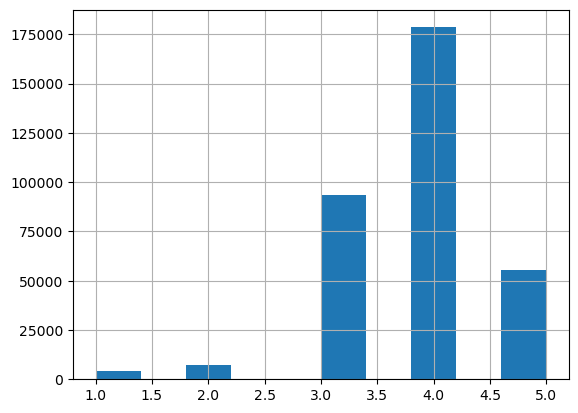

In [34]:
cars['yearCat'].hist()

In [35]:
from sklearn.model_selection import StratifiedShuffleSplit

# Split object
split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)

#.split method which splits based on above object
for train_index, test_index in split.split(cars, cars['yearCat']):
    strat_train_set = cars.loc[train_index]
    strat_test_set = cars.loc[test_index]

#### Now drop income_cat label

In [36]:
for instance_ in (strat_train_set, strat_test_set):
    instance_.drop("yearCat",axis=1,inplace=True)

## Let's think about possible correlations

In [37]:
from pandas.plotting import scatter_matrix

In [38]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338393 entries, 0 to 338392
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   price                338393 non-null  float64 
 1   abtest               338393 non-null  object  
 2   vehicleType          310238 non-null  object  
 3   yearOfRegistration   338393 non-null  int64   
 4   gearbox              324372 non-null  object  
 5   powerPS              308342 non-null  float64 
 6   kilometer            338393 non-null  int64   
 7   monthOfRegistration  338393 non-null  int64   
 8   fuelType             313994 non-null  object  
 9   notRepairedDamage    281464 non-null  object  
 10  yearCat              338393 non-null  category
dtypes: category(1), float64(2), int64(3), object(5)
memory usage: 26.1+ MB


## Preparing for analysis

In [39]:
cars = strat_train_set.drop('price',axis=1)
prices = strat_train_set['price'].copy()
prices

150635     6.00
237931     1.50
69458      8.90
231825    15.00
200014     6.20
          ...  
233055     2.05
224248     6.19
207027     1.85
61658      5.50
310757     7.89
Name: price, Length: 270714, dtype: float64

Check for missing features

In [40]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270714 entries, 150635 to 310757
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   abtest               270714 non-null  object 
 1   vehicleType          248114 non-null  object 
 2   yearOfRegistration   270714 non-null  int64  
 3   gearbox              259516 non-null  object 
 4   powerPS              246625 non-null  float64
 5   kilometer            270714 non-null  int64  
 6   monthOfRegistration  270714 non-null  int64  
 7   fuelType             251175 non-null  object 
 8   notRepairedDamage    225019 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 20.7+ MB


### All missing values are categorical!

In [41]:
for feature in cars.select_dtypes(object).columns:
    print(feature,cars[feature].value_counts().size)

abtest 2
vehicleType 8
gearbox 2
fuelType 7
notRepairedDamage 2


In [42]:
cars['fuelType'].value_counts()

benzin     162121
diesel      84179
lpg          4078
cng           434
hybrid        190
andere        100
elektro        73
Name: fuelType, dtype: int64

### Binary Categorical Pipeline

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalImputer(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    
    def fit(self, X, y=None):
        return self # nothing else to do 

    def transform(self, X):
        #if (X.isnull().any()):
            return X.fillna( X.mode() ) 

Should be able to use OneHot encoder for the non-date categorical variables

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
small_cat_pipeline = Pipeline([
    ('imputer', CategoricalImputer()),
    ('encoder', OneHotEncoder(max_categories=10))
])
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270714 entries, 150635 to 310757
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   abtest               270714 non-null  object 
 1   vehicleType          248114 non-null  object 
 2   yearOfRegistration   270714 non-null  int64  
 3   gearbox              259516 non-null  object 
 4   powerPS              246625 non-null  float64
 5   kilometer            270714 non-null  int64  
 6   monthOfRegistration  270714 non-null  int64  
 7   fuelType             251175 non-null  object 
 8   notRepairedDamage    225019 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 20.7+ MB


### Num Pipeline

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [47]:
from sklearn.compose import ColumnTransformer

num_attribs = ['yearOfRegistration','powerPS','kilometer']
not_modified = ['monthOfRegistration']
cat_attribs = ["abtest",'vehicleType','gearbox','fuelType','notRepairedDamage']

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ('nothing', 'passthrough', not_modified),
    ("cat", small_cat_pipeline, cat_attribs),
])


cars_prepared = full_pipeline.fit_transform(cars)

## Training/Evaluating on the Training Set

In [50]:
from sklearn.linear_model import LinearRegression

In [51]:
lin_reg = LinearRegression()
lin_reg.fit(cars_prepared, prices)

LinearRegression()

In [56]:
tiny_data = cars.iloc[:5]
tiny_data_labels = prices.iloc[:5]
tiny_data_prepared = full_pipeline.transform(tiny_data)

In [54]:
tiny_data_labels

150635     6.0
237931     1.5
69458      8.9
231825    15.0
200014     6.2
Name: price, dtype: float64

In [57]:
lin_reg.predict(tiny_data_prepared)

array([6.70214844, 6.04199219, 6.48876953, 9.828125  , 4.35986328])

In [61]:
from sklearn.metrics import mean_squared_error
cars_predictions = lin_reg.predict(cars_prepared)

lin_mse = mean_squared_error(cars_predictions, prices)
rmse = np.sqrt(lin_mse)
rmse

5.4908725794789355

In [62]:
prices.describe()

count    270714.000000
mean          6.068380
std           7.303194
min           0.408000
25%           1.500000
50%           3.490000
75%           7.890000
max          74.999000
Name: price, dtype: float64

Looks like the prediction is a little less than the STD. Gross.

### Try other model

In [64]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(cars_prepared, prices)

cars_predictions = tree_reg.predict(cars_prepared)

tree_mse = mean_squared_error(cars_predictions, prices)
rmse = np.sqrt(tree_mse)
rmse

0.8139952097867116

#### Low error! But possibility of overtraining

### Let's use cross-validation

In [66]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, cars_prepared, prices, 
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([3.79751419, 3.91056162, 3.88569518, 3.8402529 , 3.73249622,
       3.81070774, 3.79820451, 3.7863857 , 3.66137159, 3.6893921 ])

In [67]:
def display_scores(scores):
    print("Scores:",scores)
    print("Mean:",scores.mean())
    print("Standard Deviation:",scores.std())
display_scores(tree_rmse_scores)

Scores: [3.79751419 3.91056162 3.88569518 3.8402529  3.73249622 3.81070774
 3.79820451 3.7863857  3.66137159 3.6893921 ]
Mean: 3.791258173971528
Standard Deviation: 0.07532712079658095


In [70]:
scores = cross_val_score(lin_reg, cars_prepared, prices, 
                            scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores: [5.54472723 5.54437762 5.64552626 5.43173813 5.48512103 5.46815524
 5.5463461  5.5165748  5.42666035 5.3147569 ]
Mean: 5.492398367365118
Standard Deviation: 0.08519477188716944


Try Random Forest

In [73]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(cars_prepared, prices)

forest_scores = cross_val_score(forest_reg, cars_prepared, prices,
                               scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [2.93238977 2.97919247 2.968479   2.911752   2.91720722 2.88960846
 2.91324665 2.93933959 2.78075293 2.78071195]
Mean: 2.9012680030930644
Standard Deviation: 0.06535181676359149


## Evaluate final model on test set

In [79]:
test_X = full_pipeline.transform( strat_test_set.drop('price', axis=1) )
test_y = strat_test_set['price'].copy()

predicted_y = forest_reg.predict(test_X)

test_score = mean_squared_error(predicted_y, test_y)
final_score = np.sqrt(test_score)



In [80]:
final_score

2.9791875882039793